<h1 style="text-align: center;">✨THE LUSCHER ZETA FUNCTION✨</h1>


In [6]:
import numpy as np
import pandas as pd
from scipy.special import sph_harm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

💭What is the Luscher Zeta Function?💭 \
The Lüscher zeta function connects finite-volume energy levels to scattering phase shifts. It helps extract physical observables from lattice QCD simulations. This is crucial for studying hadron interactions and resonances. It has an infinte sum term and an integral term which we will split in three separate terms. Our goal is to code the luscher zeta function and we will begin with the infinte sum term.

This is the Luscher zeta function as defined in [X]. $$Z_\ell(s, q^2) = \sum_{\mathbf{n} \in \mathbb{Z}^3} \frac{Y_\ell(\hat{\mathbf{n}})e^{-\alpha (n^2 - q^2)}}{(|\mathbf{n}|^2 - q^2)^s} + I_{(q^2)}$$

We will begin with the infinite sum term. $$Z_\ell(s, q^2) = \sum_{\mathbf{n} \in \mathbb{Z}^3} \frac{Y_\ell(\hat{\mathbf{n}})e^{-\alpha (n^2 - q^2)}}{(|\mathbf{n}|^2 - q^2)^s} $$.

This is the infinite sum of the Luscher Zeta function. We are interested in coding this but it is impossible since it is an infinite sum. To do this we implement the Pavé summation.The Luscher Zeta function is a lattice summation over $Z^3$ with a spherical harmonic term and denominator term involving $|n|^2 - q^2$. With the pavé summation, we are summing over increasingly larger cubes in $Z^3$ while taking advantage of symmetry.

In [7]:
def spherical_harmonic(l, m, theta, phi):
    return sph_harm(m, l, phi, theta)

def norm_squared(n):
    return n @ n

In [8]:
def generate_lattice_points(L_max):
    """
    Generate lattice points during computation.
    """
    for x in range(-L_max, L_max + 1):
        for y in range(-L_max, L_max + 1):
            for z in range(-L_max, L_max + 1):
                n = np.array([x, y, z])
                if np.any(n != 0):  # Exclude the origin
                    r2 = norm_squared(n)
                    r = np.sqrt(r2)
                    theta = np.arccos(n[2] / r) if r > 0 else 0.0
                    phi = np.arctan2(n[1], n[0])
                    yield r2, theta, phi

def Z_l(s, q2, ell, L_max, epsilon):
    """
    Z_l(s, q^2) for large lattices. (If needed)
    """
    Z_l_value = 0.0 + 0.0j  # Initialize with zero (complex)
    for r2, theta, phi in generate_lattice_points(L_max):
        denominator = (r2 - q2) + epsilon * 1j
        Y_lm = spherical_harmonic(ell, 0, theta, phi)
        weight = np.exp(-alpha * (r2 - q2))
        Z_l_value += (Y_lm * weight) / denominator
    return Z_l_value

def compute_Z_l_for_q2(q2, s, ell, L_max, epsilon):
    """
    Wrapper function for computing Z_l for a given q2.
    """
    return Z_l(s, q2, ell, L_max, epsilon)

In [15]:
# Parameters
s = 1.0  # Scaling parameter (fixed to 1.0)
ell = 4  # spherical harmonic
L_max = 10
epsilon = 0.# 1e-3  # Regularisation parameter
alpha = 0.1 # exponential damping factor CHECK IF VALUE OK

# q^2 range
q2_values = np.arange(-1.0001, 5.0, 0.001)

# Parallel computation of Z_l over q2_values
Z_l_results = Parallel(n_jobs=-1)(
    delayed(compute_Z_l_for_q2)(q2, s, ell, L_max, epsilon)
    for q2 in q2_values
)

We are now ready to plot the infinte sum term(🥳).

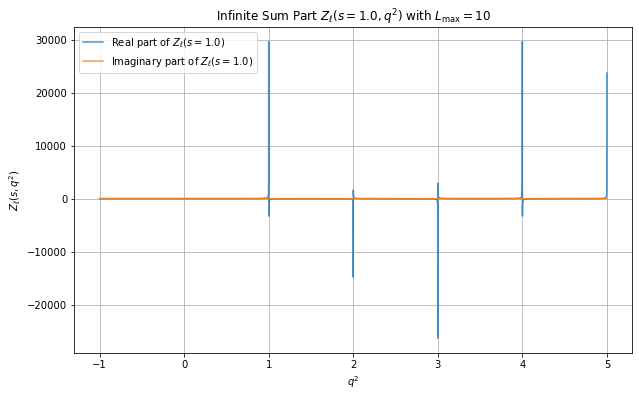

In [16]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(q2_values, [z.real for z in Z_l_results], label=f'Real part of $Z_{{\ell}}(s={s})$', alpha=0.8)
plt.plot(q2_values, [z.imag for z in Z_l_results], label=f'Imaginary part of $Z_{{\ell}}(s={s})$', alpha=0.8)

# Highlight divergence points
#for r2, _, _ in lattice_points:
#    if -1.0 <= r2 <= 5.0:
#        plt.axvline(r2, color='red', linestyle='--', alpha=0.3)

plt.xlabel('$q^2$')
plt.ylabel(f'$Z_{{\ell}}(s, q^2)$')
plt.title(f'Infinite Sum Part $Z_{{\ell}}(s={s}, q^2)$ with $L_\mathrm{{max}}={L_max}$')
plt.legend()
plt.grid(True)
plt.show()

The infinite sum term looks like it behaves as a tan as expected.

-----------------------------------***NOW WE WILL DO THE INTEGRAL TERM🚀💫📚***------------------------------------

The integral term $ I(q^2) $ can be separated to three distinct parts to handle different momentum regions. We have:

### 1. Low-Momentum Contribution 

This integral represents the contribution from the low-momentum region, where the momentum $ r $ is small. It is integrated from $ 0 $ to an intermediate cutoff $ \Lambda_{\text{low}} $, which avoids the singularity near $ r = \sqrt{q^2} $.

$$
I_{\text{low}}(q^2) = \int_{0}^{\Lambda_{\text{low}}} \frac{r^2 \, dr}{(2\pi)^3} \frac{Y_\ell(\hat{\mathbf{r}})e^{-\alpha (n^2 - q^2)}}{r^2 - q^2}
$$

### 2. Singular Region Contribution

This integral handles the contribution from the region near the singularity at $ r = \sqrt{q^2} $. To properly deal with the singularity, the integral is split into two parts: one just below $ \sqrt{q^2} $ and one just above it. A small exclusion region of size $ \delta $ is used around the singularity, and the **principal value** (P.V.) of the integral is taken.

$$
I(q^2, \alpha, \Delta) =
\left(
\int^{\Lambda} d^3n \ 
\frac{e^{-\alpha (n^2 - q^2)} - 1}{n^2 - q^2}
\right)
+ P \int^{\Lambda} d^3n \frac{1}{n^2 - q^2}
$$

Here, the first integral requires numerical evaluation because of the exponential damping term, which complicates the analytical treatment.The second integral can be solved analytically and is 

$$
2\pi q \left( \frac{2\Lambda}{q} - 2 \operatorname{Arctanh}(\Lambda/q) \right)
$$


### 3. High-Momentum Contribution 

This integral represents the contribution from the high-momentum region, where the momentum $ r $ is large. It is integrated from a high cutoff $ \Lambda_{\text{high}} $ to infinity. To ensure proper convergence, an asymptotic approximation is used for the tail of the integral.

$$
I_{\text{high}}(q^2) = \int_{\Lambda_{\text{high}}}^{\infty} \frac{r^2 \, dr}{(2\pi)^3} \frac{Y_\ell(\hat{\mathbf{r}})e^{-\alpha (n^2 - q^2)}}{r^2 - q^2}
$$

Total Integral

The total integral $ I(q^2) $ is obtained by summing the three contributions:

$$
I(q^2) = I_{\text{low}}(q^2) + I_{\text{sing}}(q^2) + I_{\text{high}}(q^2)
$$



In [17]:
# Define angular integral normalization
def angular_integral(ell):
    return (2 * ell + 1) / (4 * np.pi)

# Radial integrand for Singular Region Contribution (Numerical)
def singular_integrand(n, q2, alpha):
    if np.isclose(n**2, q2, atol=1e-10):  # Avoid division by zero
        return 0
    return (n**2) * (np.exp(-alpha * (n**2 - q2)) - 1) / (n**2 - q2)

# Analytical contribution (as given in the blackboard derivation)
def analytic_contribution(q2, Lambda):
    if Lambda <= 0 or q2 <= 0:
        return 0  # Avoid unphysical cases
    
    return 2 * np.pi * q2**0.5 * (2 * Lambda / q2**0.5 - 2 * np.arctanh(Lambda / q2**0.5))

# Singular momentum integral (Numerically evaluated term + Analytical contribution)
def I_sing(q2, ell, Lambda_low, Lambda_high, alpha):
    angular_weight = angular_integral(ell)

    # Perform the integral numerically over n
    left_integral, _ = quad(singular_integrand, Lambda_low, np.sqrt(q2) - 1e-3, args=(q2, alpha), epsabs=1e-7, epsrel=1e-7)
    right_integral, _ = quad(singular_integrand, np.sqrt(q2) + 1e-3, Lambda_high, args=(q2, alpha), epsabs=1e-7, epsrel=1e-7)

    # Compute the analytical contribution
    analytic_term = analytic_contribution(q2, Lambda_high)

    return (4 * np.pi * angular_weight) * (left_integral + right_integral) / (2 * np.pi**3) + analytic_term

# Radial integrand (for other integrals)
def integrand(r, q2, ell, alpha, epsilon):
    angular_weight = angular_integral(ell)
    exponential_damping = np.exp(-alpha * (r**2 - q2))  # Correct damping term
    return (r**2 / (2 * np.pi**3)) * angular_weight * exponential_damping / (r**2 - q2 + epsilon)

# Low-momentum integral
def I_low(q2, ell, Lambda_low, alpha, epsilon):
    result, _ = quad(integrand, 0, Lambda_low, args=(q2, ell, alpha, epsilon), epsabs=1e-7, epsrel=1e-7)
    return result

# High-momentum integral (updated with exponential damping)
def I_high(q2, ell, Lambda_high, alpha, epsilon):
    result, _ = quad(
        integrand, Lambda_high, np.inf, args=(q2, ell, alpha, epsilon), limit=500,
        epsabs=1e-7, epsrel=1e-7
    )
    return result

# Total integral
def total_integral(q2, ell, Lambda_low, Lambda_high, alpha, epsilon):
    I_low_val = I_low(q2, ell, Lambda_low, alpha, epsilon)
    I_sing_val = I_sing(q2, ell, Lambda_low, Lambda_high, alpha)
    I_high_val = I_high(q2, ell, Lambda_high, alpha, epsilon)
    return I_low_val + I_sing_val + I_high_val


In [18]:
# Full F(q^2, Lambda_high)
def F(q2, s, ell, L_max, epsilon, Lambda_low, Lambda_high, alpha):
    Z_l_val = Z_l(s, q2, ell, L_max, epsilon)
    integral_val = total_integral(q2, ell, Lambda_low, Lambda_high, alpha, epsilon)
    return Z_l_val + integral_val

# Function to plot F vs Lambda_high for a fixed alpha
def plot_F_vs_Lambda_high(Lambda_high_values, F_values, q2, alpha):
    """
    Plot F(q^2, Lambda_high) vs Lambda_high for a fixed alpha.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot the real and imaginary parts of F
    plt.plot(Lambda_high_values, [np.real(f) for f in F_values], label="Real part of $F$", alpha=0.8)
    # plt.plot(Lambda_high_values, [np.imag(f) for f in F_values], label="Imaginary part of $F$", alpha=0.8, linestyle="--")

    # Add labels, title, and grid
    plt.xlabel(r"$\Lambda_{\mathrm{high}}$", fontsize=14)
    plt.ylabel(r"$F(q^2, \Lambda_{\mathrm{high}})$", fontsize=14)
    plt.title(f"$F(q^2, \\Lambda_{{\\mathrm{{high}}}})$ vs $\\Lambda_{{\\mathrm{{high}}}}$ for $q^2={q2}$, $\\alpha={alpha}$", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


Let's plot that!

<ipython-input-17-066d9d8c03b9>:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(
<ipython-input-17-066d9d8c03b9>:16: RuntimeWarning: invalid value encountered in arctanh
  return 2 * np.pi * q2**0.5 * (2 * Lambda / q2**0.5 - 2 * np.arctanh(Lambda / q2**0.5))


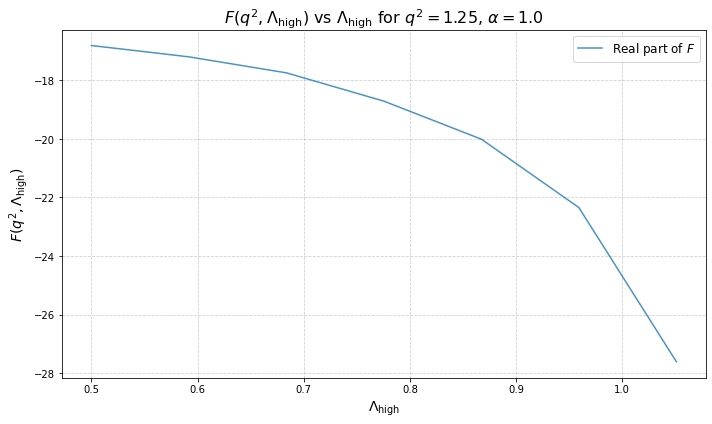

In [20]:
# Parametres for analysis
s = 1.0
ell = 4
L_max = 10
epsilon = 1e-3
Lambda_low = 0.5
q2 = 1.25  # Fixed energy
alpha = 1.0  # Fixed alpha
# Lambda_high_values = np.linspace(1.0, 15.0, 50)  # Range of Lambda_high
Lambda_high_values = np.linspace(0.5, 5.0, 50)  # Increase range


# Compute F(q^2, Lambda_high) for the fixed alpha
F_values = [
    F(q2, s, ell, L_max, epsilon, Lambda_low, Lambda_high, alpha)
    for Lambda_high in Lambda_high_values
]

# Plot F vs Lambda_high
plot_F_vs_Lambda_high(Lambda_high_values, F_values, q2, alpha)

In [24]:
# Function to plot normalized F
def plot_normalized_F(results_df):
    plt.figure(figsize=(10, 6))
    for alpha in sorted(results_df["alpha"].unique()):  # FIXED: "Alpha" -> "alpha"
        subset = results_df[results_df["alpha"] == alpha]
        plt.plot(
            subset["Lambda_high"],
            subset["F_total"] / subset["Lambda_high"],
            label=f"Normalized F, alpha = {alpha}"
        )
    plt.xlabel(r"$\Lambda_{\mathrm{high}}$", fontsize=14)
    plt.ylabel(r"$F(q^2, \Lambda_{\mathrm{high}})/\Lambda_{\mathrm{high}}$", fontsize=14)
    plt.title(r"Normalized $F(q^2, \Lambda_{\mathrm{high}})$ vs $\Lambda_{\mathrm{high}}$ for varying $\alpha$", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()




The following cell will only make sense once i find the literature values to check which is why it is now commeneted out.

In [ ]:
'''# Validation test
def validate_results():
    """
    Compare the results for specific parameters to known analytical or published results.
    Replace reference values with known benchmarks.
    """
    q2 = 1.25
    ell = 4
    s = 1.0
    L_max = 15
    epsilon = 1e-10
    Lambda_low = 0.5
    Lambda_high = 10.0
    alpha = 1.0

    computed_Z_l = Z_l(s, q2, ell, L_max, epsilon)
    computed_F = F(q2, s, ell, L_max, epsilon, Lambda_low, Lambda_high, alpha)
    
    reference_Z_l = # FIND IN A PAPER
    reference_F = # FIND IN A PAPER

    print(f"Computed Z_l: {computed_Z_l}, Reference Z_l: {reference_Z_l}")
    print(f"Computed F: {computed_F}, Reference F: {reference_F}")
    
    # Check for agreement
    Z_l_error = np.abs(computed_Z_l - reference_Z_l) / np.abs(reference_Z_l)
    F_error = np.abs(computed_F - reference_F) / np.abs(reference_F)

    print(f"Relative error in Z_l: {Z_l_error:.6e}")
    print(f"Relative error in F: {F_error:.6e}")


Note on the normalisation below: 
$$
\frac{F(q^2, \Lambda_{\text{high}})}{\Lambda_{\text{high}}}
$$
where $\Lambda_{high}$ is an upper cutoff in the momentum integral used in your calculations of $F(q^2,\Lambda_{high} )$.


<ipython-input-17-066d9d8c03b9>:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(
<ipython-input-17-066d9d8c03b9>:16: RuntimeWarning: invalid value encountered in arctanh
  return 2 * np.pi * q2**0.5 * (2 * Lambda / q2**0.5 - 2 * np.arctanh(Lambda / q2**0.5))


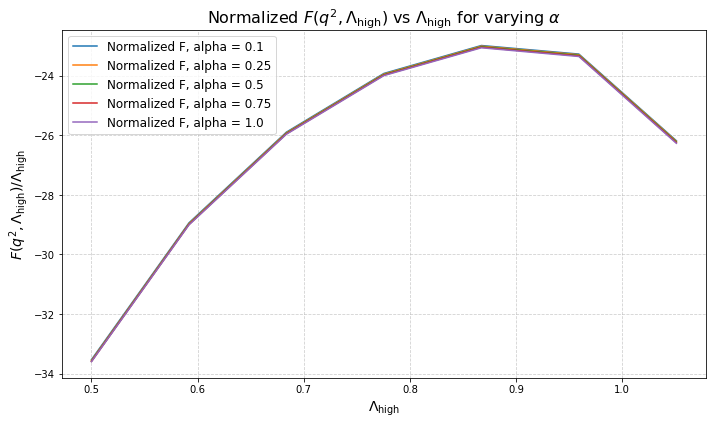

NameError: name 'validate_results' is not defined

In [ ]:
# Parametres for analysis
s = 1.0
ell = 4
L_max = 15
epsilon = 1e-10
Lambda_low = 0.5
q2 = 1.25
alpha_values = [1.0, 0.75, 0.5, 0.25, 0.1]
# Lambda_high_values = np.linspace(1.0, 15.0, 10)
Lambda_high_values = np.linspace(0.5, 5.0, 50)  # Increase range

#new bit, not sure
def compute_F_with_alpha(alpha_values, Lambda_high_values, s, q2, ell, L_max, epsilon, Lambda_low):
    results = []
    for alpha in alpha_values:
        F_values = [
            F(q2, s, ell, L_max, epsilon, Lambda_low, Lambda_high, alpha)
            for Lambda_high in Lambda_high_values
        ]
        for Lambda_high, F_val in zip(Lambda_high_values, F_values):
            results.append({
                "alpha": alpha,
                "Lambda_high": Lambda_high,
                "F_total": np.real(F_val)  # Ensure consistency with plotting function
            })
    return pd.DataFrame(results)



# F(q^2, Lambda_high)
results_df = compute_F_with_alpha(alpha_values, Lambda_high_values, s, q2, ell, L_max, epsilon, Lambda_low)

# Plot normalised F
plot_normalized_F(results_df)

# Validate results
# validate_results(results_df)



That looks as expected! The following plot i for visual purposes only! It is the same plot as above but with offsests so thatt all cures are clearly separated. We see the trens in normalised F(q^2, Lamba_{high} for varying alpha}).⚠️The offsets are not physically meaningful!⚠️ 

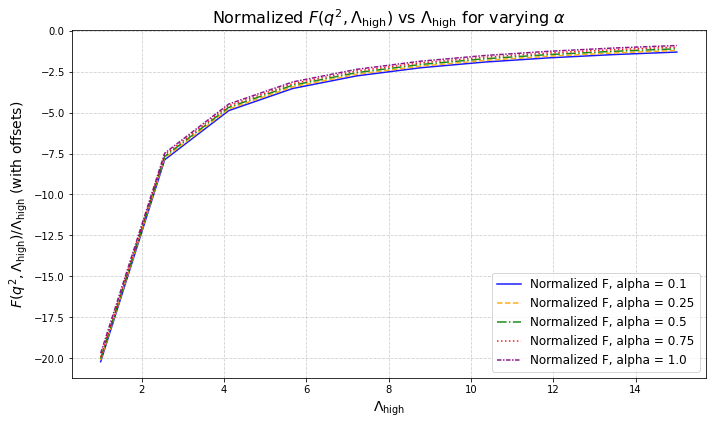

In [ ]:
def plot_normalized_F_with_offsets(results_df):
    plt.figure(figsize=(10, 6))
    
    # Define line styles and colors
    line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    
    # Loop over unique alpha values in the results
    for i, alpha in enumerate(sorted(results_df["Alpha"].unique())):
        subset = results_df[results_df["Alpha"] == alpha]
        
        # Add an artificial vertical offset for visualization
        offset = i * 0.1  # Adjust offset value as needed
        plt.plot(
            subset["Lambda_high"],
            (subset["F_total"] / subset["Lambda_high"]) + offset,  # Add offset
            label=f"Normalized F, alpha = {alpha}",
            linestyle=line_styles[i % len(line_styles)],
            color=colors[i % len(colors)],
            alpha=0.9  # Transparency
        )
    
    # Add labels, legend, and grid
    plt.xlabel(r"$\Lambda_{\mathrm{high}}$", fontsize=14)
    plt.ylabel(r"$F(q^2, \Lambda_{\mathrm{high}})/\Lambda_{\mathrm{high}}$ (with offsets)", fontsize=14)
    plt.title(r"Normalized $F(q^2, \Lambda_{\mathrm{high}})$ vs $\Lambda_{\mathrm{high}}$ for varying $\alpha$", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_normalized_F_with_offsets(results_df)
